In [1]:
import sys
import os
import subprocess
import tarfile
import shutil
import random
from functools import partial
from tqdm import tqdm
from tqdm.auto import tqdm
tqdm.pandas()

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (random_split, DataLoader, TensorDataset, ConcatDataset)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
from Bio import motifs
import pickle
from datetime import datetime
import scipy.stats as stats
import math

import boda
from boda.common import constants, utils

boda_src = os.path.join( os.path.dirname( os.path.dirname( os.getcwd() ) ), 'src' )
sys.path.insert(0, boda_src)

from main import unpack_artifact, model_fn
from pymeme import streme, parse_streme_output

from torch.distributions.categorical import Categorical
from boda.generator.plot_tools import matrix_to_dms, ppm_to_IC, ppm_to_pwm, counts_to_ppm

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
rootdir = 'fads_locus/contributions_v1'

chunk_dicts = {}
for subdir, dirs, files in os.walk(rootdir):
    for file in tqdm(files):
        full_coordinates = file.split('__')[-1].rstrip('.pt')
        chunk_dicts[full_coordinates] = torch.load(os.path.join(rootdir, file))

  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
all_window_contributions = torch.cat([chunk_dicts[key]['window_contributions'] for key in sorted(chunk_dicts.keys())])
all_window_coordinates = [coordinate for key in sorted(chunk_dicts.keys()) for coordinate in chunk_dicts[key]['window_coordinates']]

In [4]:
def is_list_sorted(l):
    return all(l[i] <= l[i+1] for i in range(len(l)-1))

is_list_sorted(all_window_coordinates)

True

In [5]:
step_size = 10
num_channels = 4

num_windows = all_window_contributions.shape[0]
window_size = all_window_contributions.shape[-1]
locus_length = step_size * (num_windows - 1) + window_size

last_window_start =  step_size * (num_windows - 1)
full_window_contributions = torch.zeros(num_channels, locus_length).cuda()
for i in tqdm(range(0, last_window_start, step_size)):
    full_window_contributions[:,i:i+window_size] += all_window_contributions[i//step_size,:,:].detach()

  0%|          | 0/11121 [00:00<?, ?it/s]

In [6]:
#chop tails and average over windows

max_num_windows_per_position = math.ceil(window_size / step_size)
locus_contributions = (full_window_contributions[:,200:-200] / max_num_windows_per_position).cpu()

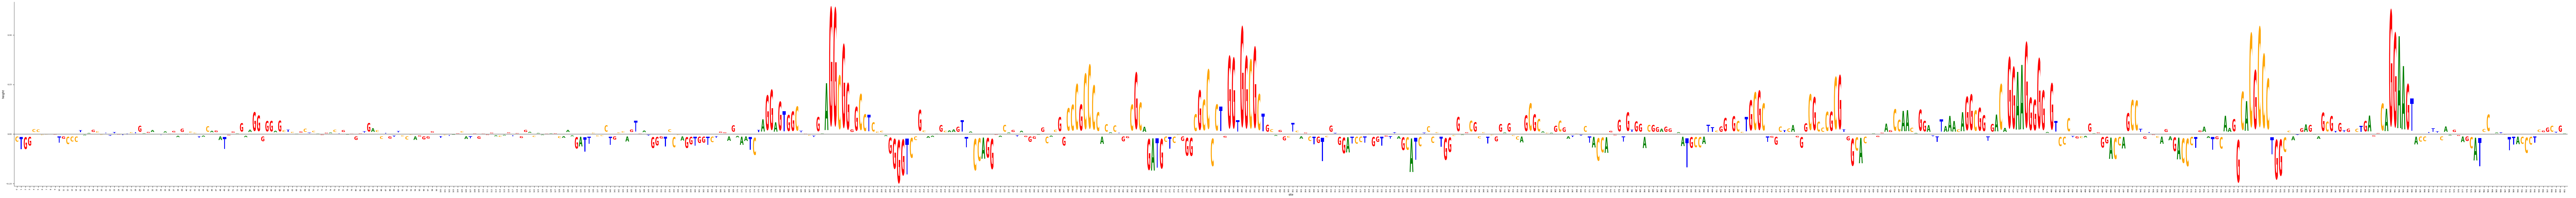

In [8]:
idx_1 = 61871018 - 61787329
idx2 = 61871620 - 61787329

matrix = locus_contributions[:,idx_1:idx2].view(4,-1)
y_max = matrix.max()
fig, ax = matrix_to_dms(matrix, y_max=y_max, fontaspect=.65, widthscale=0.8,
                  axisfontscale=0.6, heightscale=5)
plt.show()

In [9]:
flat_contributions = locus_contributions.sum(dim=0).numpy()

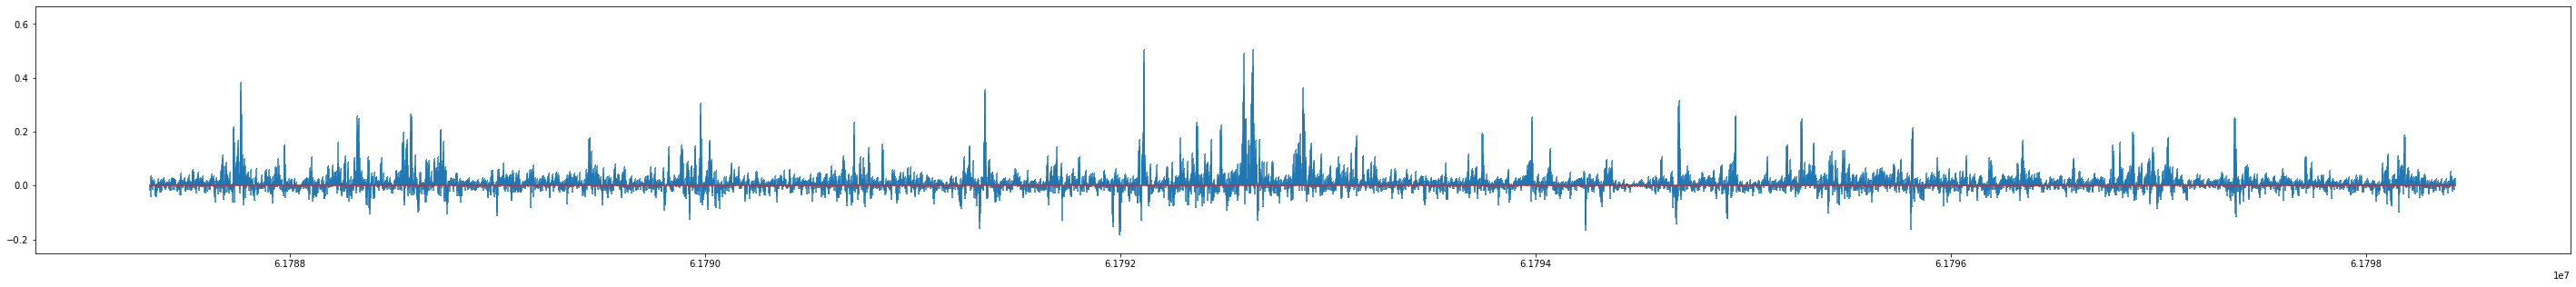

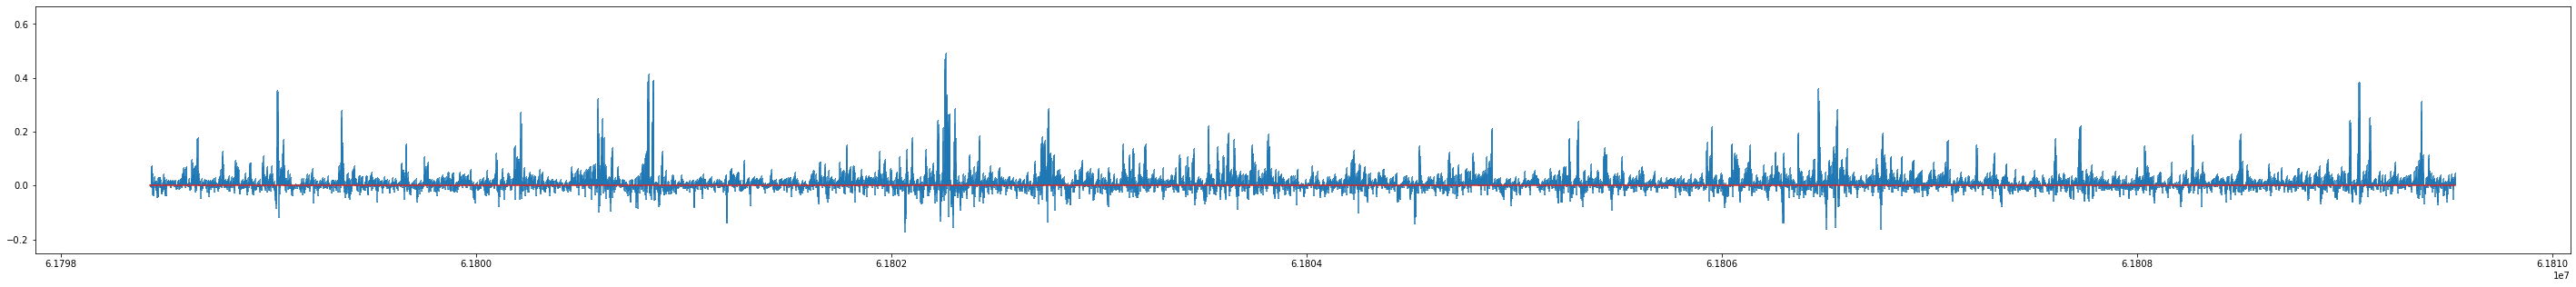

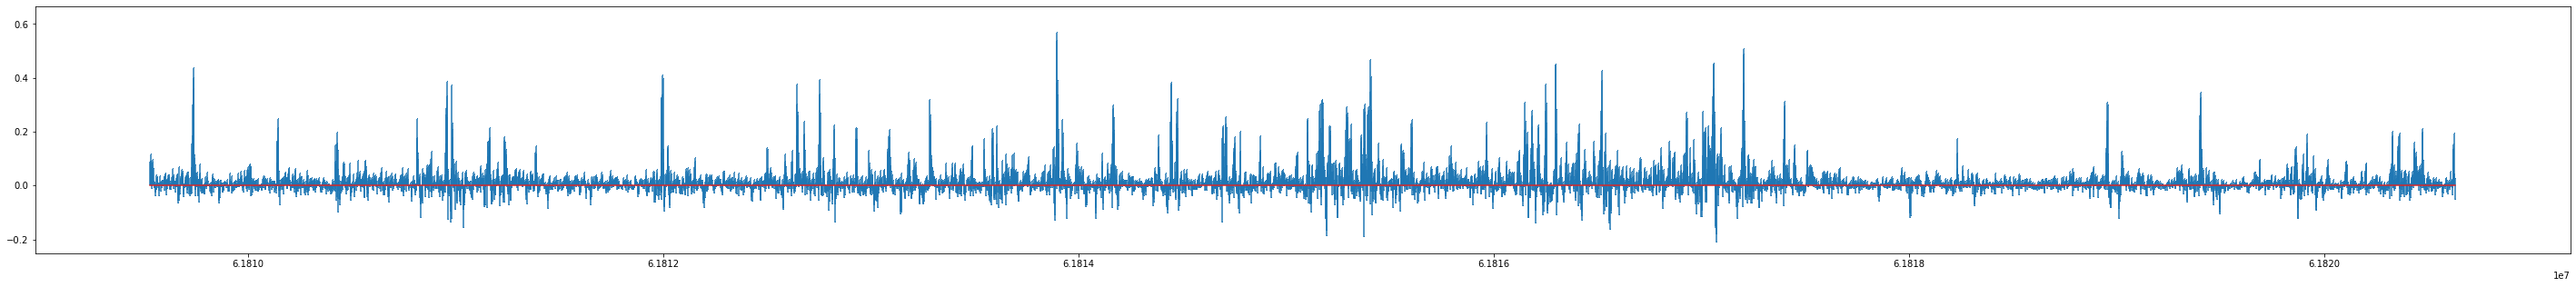

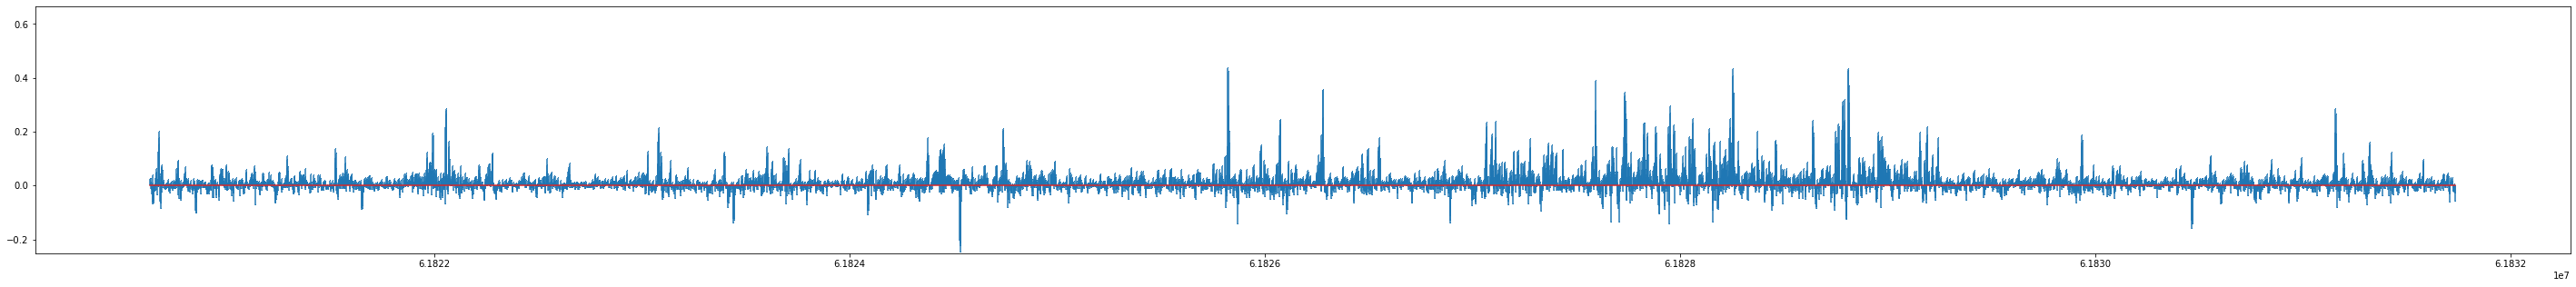

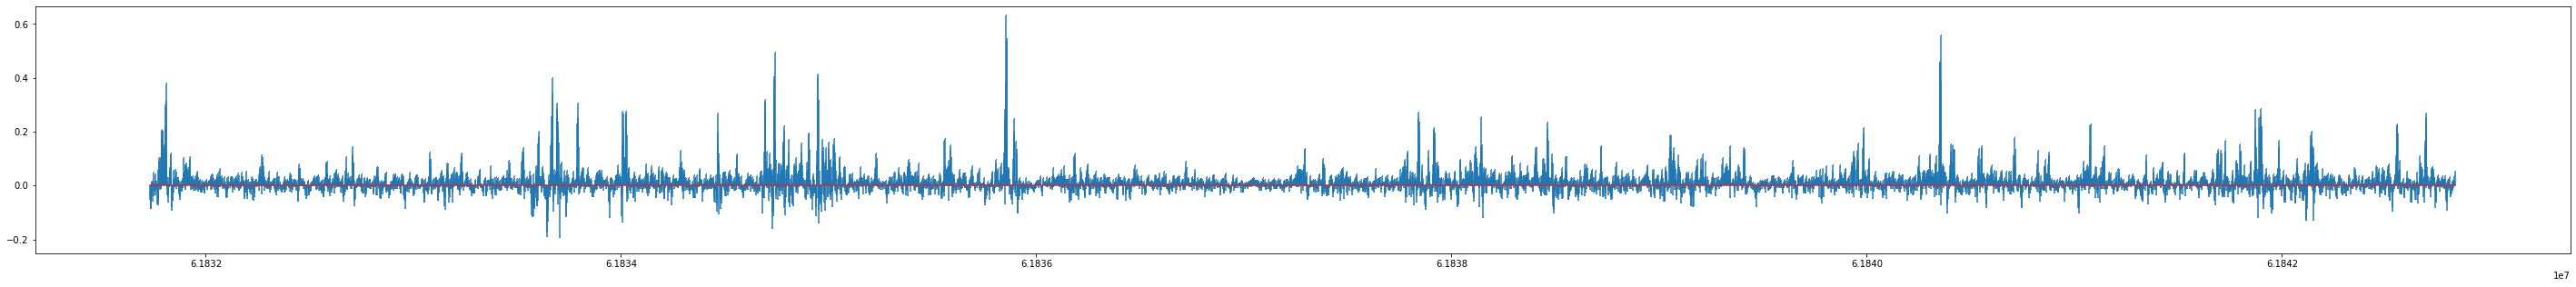

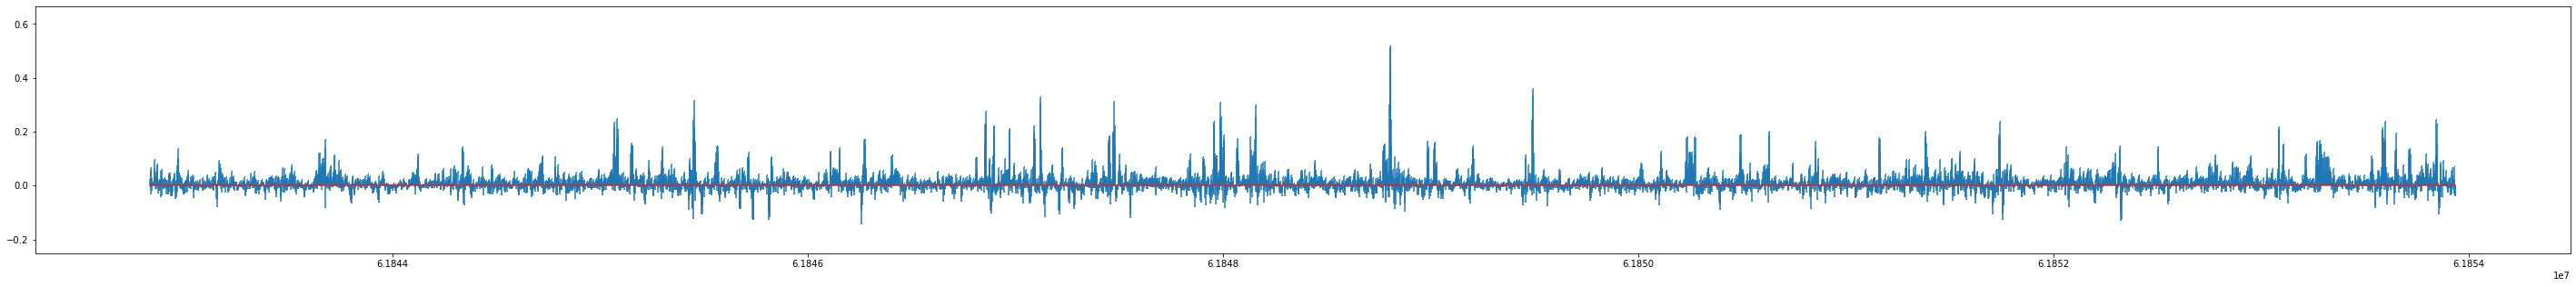

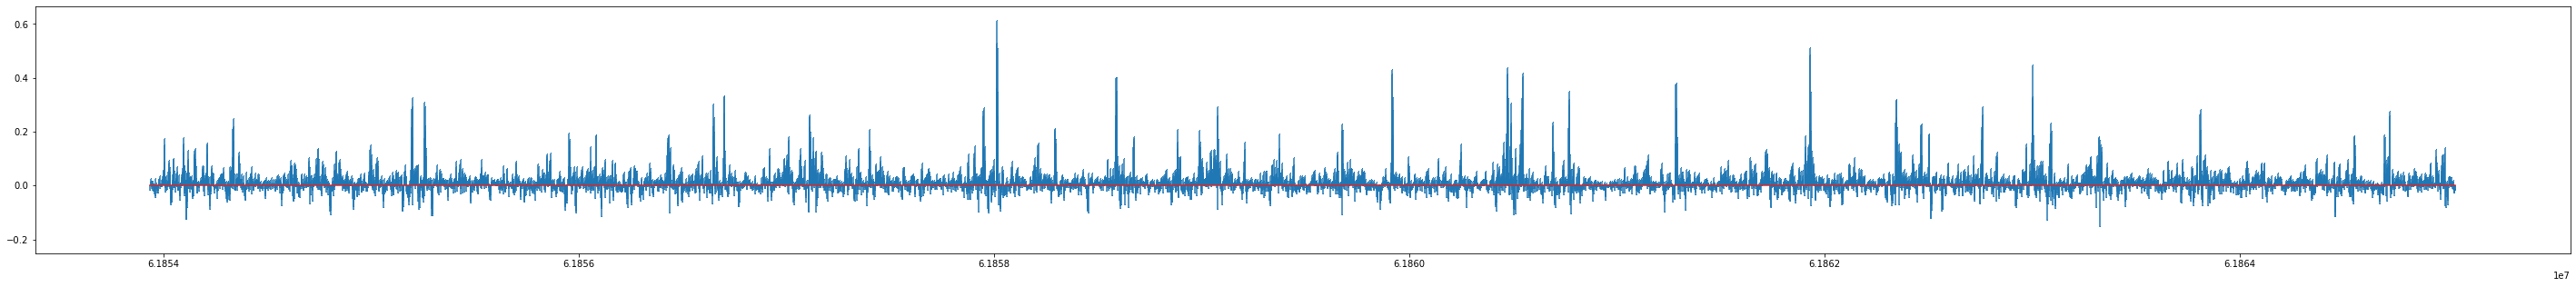

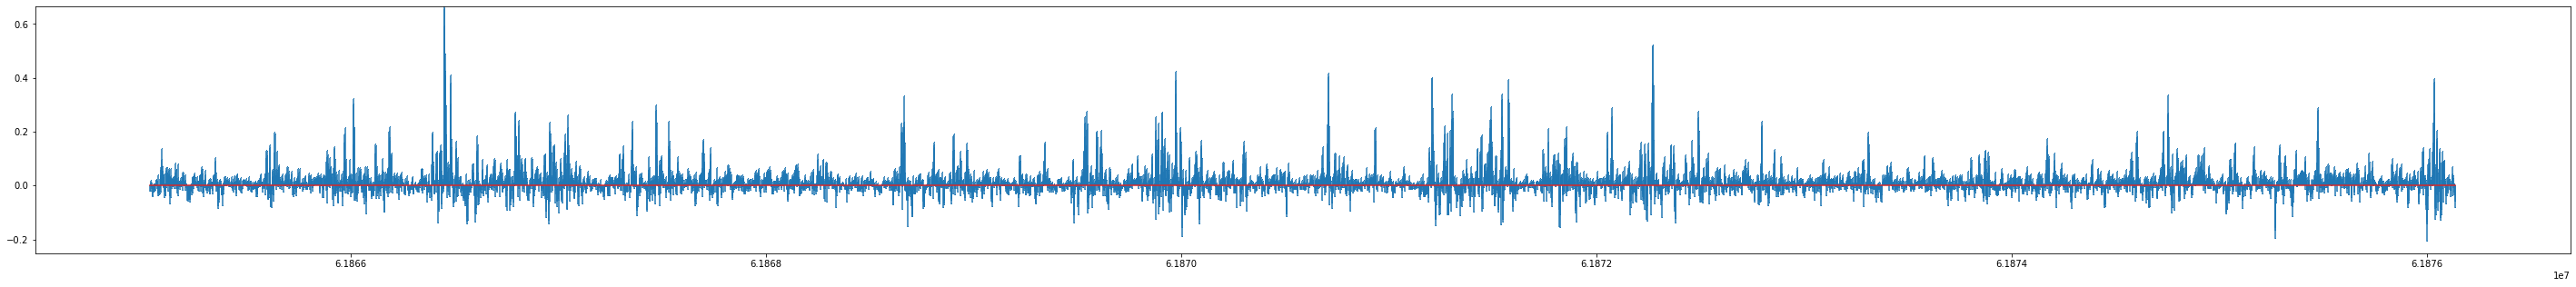

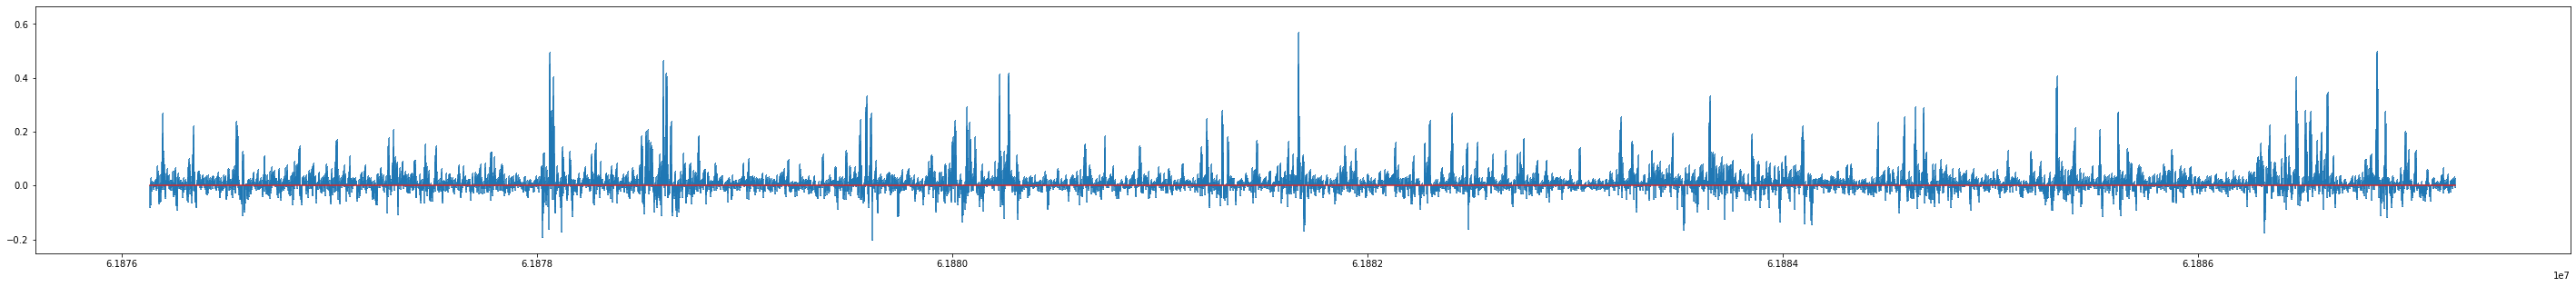

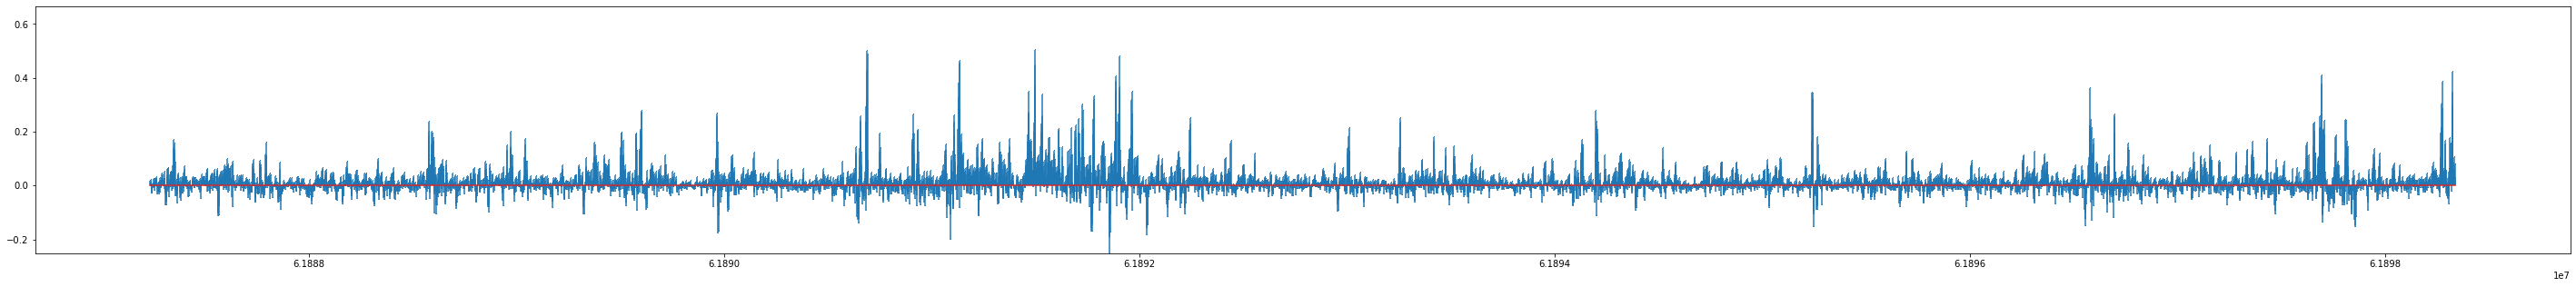

In [17]:
locus_start_idx = 61787329
locus_end_idx = 61898348
fig_length = 11101 #10000

max_contribution = flat_contributions.max()
min_contribution = flat_contributions.min()
for window_start in (range(0, len(flat_contributions), fig_length)):
    plt.figure(figsize=(50,5))
    heads = flat_contributions[window_start : window_start + fig_length]
    locs = np.arange(locus_start_idx + window_start, locus_start_idx + window_start + fig_length)
    plt.stem(locs, heads, markerfmt=',', use_line_collection=True)
    plt.ylim(min_contribution, max_contribution)
    plt.show()

### Save into a file

In [18]:
contribution_list = flat_contributions.tolist()

file_name = 'contributions__k562__chr11_61787329-61898348__hg38__v1.wig'
save_path = os.path.join('fads_locus', file_name)
header = 'fixedStep chrom=chr11 start=61787329 step=1'
contribution_list.insert(0, header)

with open(save_path, "w") as f:
    for s in contribution_list:
        f.write(str(s) +"\n")